In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import sys
import warnings
warnings.filterwarnings("ignore")

# Add src folder to path to import our custom utils
sys.path.append('../src')
from utils import compare_metrics, plot_forecasts

print("Libraries loaded.")

Libraries loaded.


In [131]:
df = pd.read_csv('data/processed/df_stationary.csv', index_col=0, parse_dates=True)

## VAR-X model

In [132]:
# ENDOGENOUS: All economic variables (Domestic + Global)
# The model will forecast ALL of these simultaneously.
endo_vars = [
    'DLOG_Y_IPI',    # Target
    'X_PPI_Growth',  # Inflation
    'D_X_UNEMP',     # Unemployment
    'DLOG_X_OIL',    # Global Oil (modeled as feedback)
    'LOG_X_CLI'      # Global Sentiment (modeled as feedback)
]

# EXOGENOUS: Only the Dummies (Deterministic Shocks)
# These are known fixed values (0 in the future).
exog_vars = ['D_COVID', 'D_2008']

# Train/Test Split
n_obs = len(df)
n_test = int(n_obs * 0.20)
test_start_index = n_obs - n_test

print(f"Test Set Size: {n_test} months")
print(f"Split Date: {df.index[test_start_index]}")

Test Set Size: 54 months
Split Date: 2018-06-01 00:00:00


### Lag Selection

Before running the loop, we check the optimal lag order ($p$) on the training data to avoid data leakage.

In [135]:
# CRITICAL: Clear lists before running the loop
preds_growth = []
preds_level = []

# Initialize history
history_endo = df[endo_vars].iloc[:test_start_index].copy()
history_exog = df[exog_vars].iloc[:test_start_index].copy()

# Find target column index
target_col_idx = endo_vars.index('DLOG_Y_IPI')

# Select lag order once
initial_model = VAR(history_endo, exog=history_exog)
lag_selection = initial_model.select_order(maxlags=12)
optimal_lag = lag_selection.aic
print("The optimal lag is:",optimal_lag)

The optimal lag is: 4


So we will run $VAR-X(4)$

### Expanding-Window Training

In [136]:
for t in range(len(actual_levels)):
    # Fit Model
    model = VAR(history_endo, exog=history_exog)
    model_fit = model.fit(optimal_lag)
    
    # Prepare Inputs
    last_obs = history_endo.values[-optimal_lag:]
    next_idx = test_start_index + t
    future_exog = df[exog_vars].iloc[next_idx].values.reshape(1, -1)
    
    # Forecast Growth
    fc = model_fit.forecast(y=last_obs, exog_future=future_exog, steps=1)
    pred_growth = fc[0, target_col_idx]
    
    # Reconstruct Level: exp( Last_Actual_Log_Level + Predicted_Growth )
    last_actual_log_level = df['LOG_Y_IPI'].iloc[next_idx - 1]
    pred_level = np.exp(last_actual_log_level + pred_growth)
    
    preds_level.append(pred_level)
    
    # Update History
    next_row_endo = df[endo_vars].iloc[next_idx]
    next_row_exog = df[exog_vars].iloc[next_idx]
    history_endo.loc[next_row_endo.name] = next_row_endo
    history_exog.loc[next_row_exog.name] = next_row_exog

print(f"Forecast Complete. Predictions generated: {len(preds_level)}")

Forecast Complete. Predictions generated: 54


In [137]:
# 3. Benchmark (Random Walk)
# ==========================================
# Shift actual levels by 1 to simulate "Tomorrow = Today"
pred_rw_level = actual_levels.shift(1)
pred_rw_level.iloc[0] = np.exp(df['LOG_Y_IPI'].iloc[test_start_index - 1])

### Evaluation

In [141]:
# Create series with correct index
varx_series = pd.Series(preds_level, index=actual_levels.index)

preds_dict = {
    'VAR-X': varx_series,
    'Random Walk': pred_rw_level
}

print("\n--- Final Evaluation (RMSE on Original Levels) ---")
metrics_df = compare_metrics(actual_levels, preds_dict)
print(metrics_df)


--- Final Evaluation (RMSE on Original Levels) ---
                  RMSE
Random Walk   6.235937
VAR-X        10.427251
None


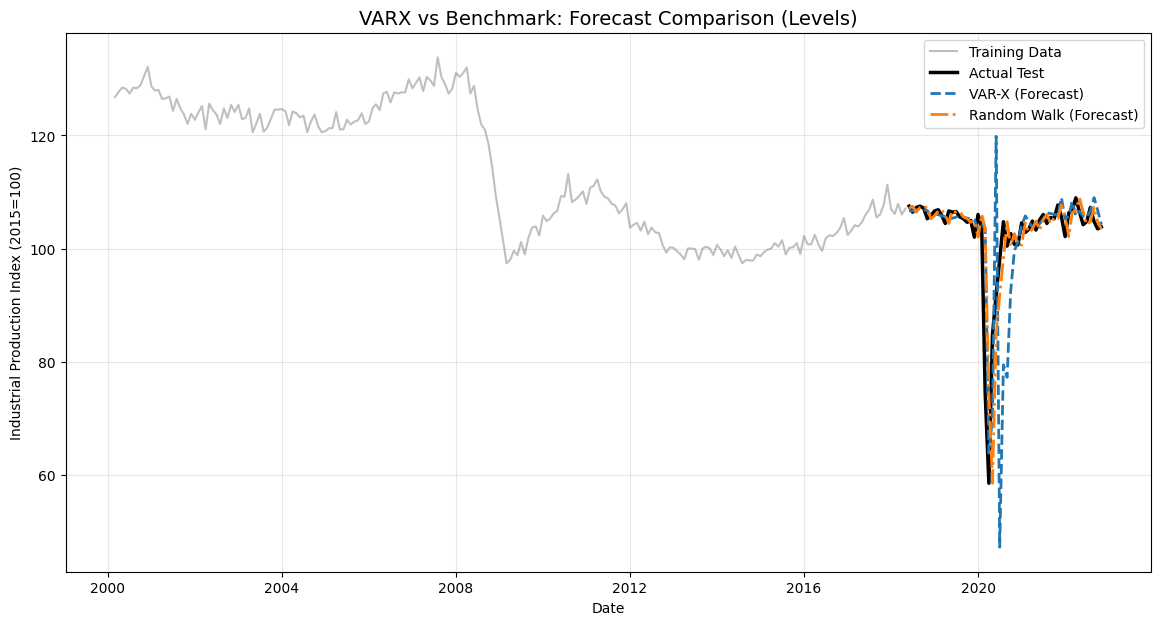

In [142]:
plot_forecasts(
    test=actual_levels,
    predictions_dict=preds_dict,
    train=np.exp(df['LOG_Y_IPI'].iloc[:test_start_index]),
    title="VARX vs Benchmark: Forecast Comparison (Levels)",
    ylabel="Industrial Production Index (2015=100)"
)

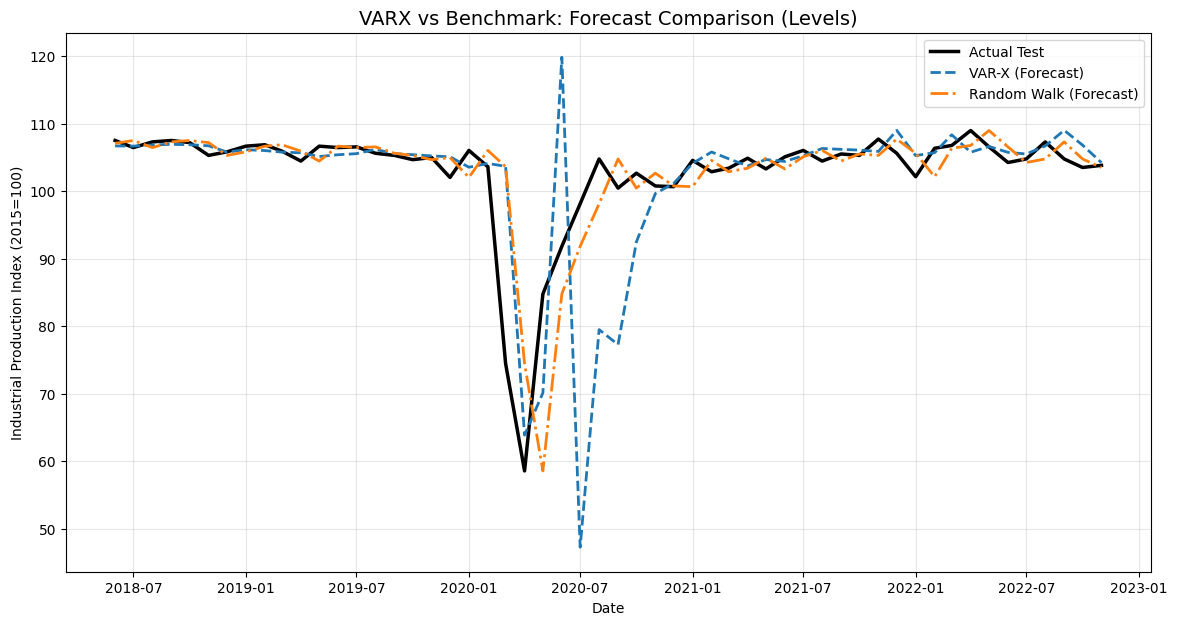

In [143]:
plot_forecasts(
    test=actual_levels,
    predictions_dict=preds_dict,
    train=None,
    title="VARX vs Benchmark: Forecast Comparison (Levels)",
    ylabel="Industrial Production Index (2015=100)"
)